[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Harvard-CS1090/2026_CS1090B_public/blob/main/sec01/cs1090b_sec01_solutions.ipynb)

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090B Introduction to Data Science

## Section 1:  Anatomy of a Neural Network, NNs with PyTorch, & NN Interpretation

**Harvard University**<br/>
**Spring 2026**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Gumb<br/>
<br/>

## Setup: Download Data

Run this cell first to download the required data files from GitHub.

In [1]:
# Environment detection and setup
import os
import subprocess
import sys
import shutil

# Define the zip file URL and expected directories
assets_zip_url = "https://github.com/Harvard-CS1090/2026_CS1090B_public/raw/main/sec01/notebook_assets.zip"

assets_zip_name = "notebook_assets.zip"
expected_dirs = ["data", "fig"]

# Check if required directories already exist
all_dirs_exist = all(os.path.isdir(d) for d in expected_dirs)

if all_dirs_exist:
    print("Required directories already exist. Skipping download.")
else:
    print(f"Downloading {assets_zip_name} from GitHub...")
    
    # Use wget in Colab, or urllib for local
    try:
        if 'google.colab' in sys.modules:
            subprocess.run(['wget', '-q', assets_zip_url], check=True)
        else:
            import urllib.request
            urllib.request.urlretrieve(assets_zip_url, assets_zip_name)
        print(f"Downloaded {assets_zip_name}.")
        
        # Unzip the file
        import zipfile
        with zipfile.ZipFile(assets_zip_name, 'r') as zip_ref:
            zip_ref.extractall('.')
        print(f"Extracted {assets_zip_name}.")
        
        # Clean up the zip file
        os.remove(assets_zip_name)
        print(f"Removed {assets_zip_name}.")
        
        # Remove __MACOSX folder if it exists
        if os.path.isdir('__MACOSX'):
            shutil.rmtree('__MACOSX')
            print("Removed __MACOSX folder.")
        
    except Exception as e:
        print(f"Error during setup: {e}", file=sys.stderr)

print("Setup complete!")

Required directories already exist. Skipping download.
Setup complete!


In [2]:
# Standard library
from collections import Counter

# Data science
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.10.0


## Part 1:  Anatomy of a Neural Network

To learn about the components of a neural network, we'll attempt to model the following data as a binary classification problem.

In [3]:
# Load data from CSV
df = pd.read_csv('data/toydata.csv')
x = df.x.values
y = df.y.values
print(df.shape)
df.head()

(100, 2)


,x,y
0,1.454849,0
1,-0.491639,1
2,0.230769,1
3,-1.575251,0
4,1.695652,0


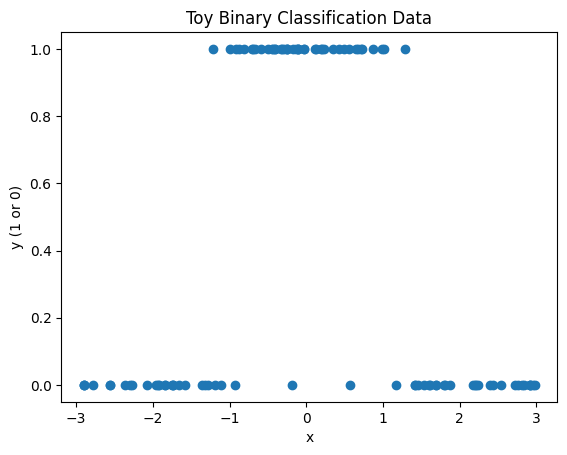

In [4]:
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y (1 or 0)')
plt.title("Toy Binary Classification Data");

Our modeling assumptions are:

$Y \sim Bern(p)$  `(Y follows a Bernoulli distribution with parameter p)`

and

$p = f(x)$

That is, the probability that $Y=1$ is a function of $x$.

---

### Neural Networks as a Composition of Functions

So how do we learn this function $f$? A neural network is a composition of many simple functions. In this example our basic building block will be the **rectified linear unit**, or **ReLU**.

In [5]:
def relu(z: np.ndarray) -> np.ndarray :
    return  np.maximum(0, z)
# or
# relu = lambda z: np.maximum(0, z)

In [6]:
# Create an input vector of dummy x values
x_lin = np.linspace(-3,3,300)

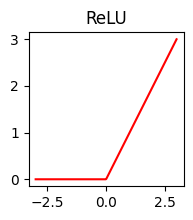

In [7]:
# Plot the ReLU function
plt.figure(figsize=(2,2))
plt.plot(x_lin, relu(x_lin), c='r')
plt.title('ReLU');

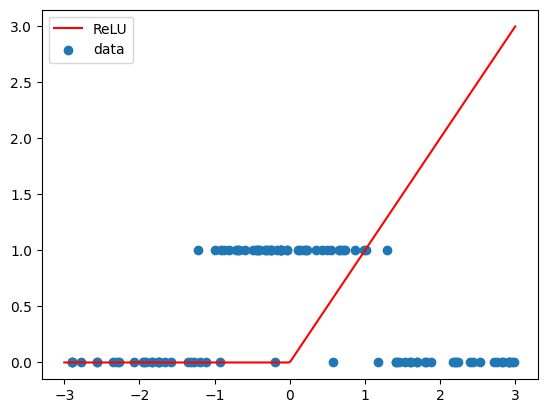

In [8]:
# With data scatter plot
plt.plot(x_lin, relu(x_lin), c='r', label='ReLU')
plt.scatter(x, y, label='data')
plt.legend();

### Affine Transformation: weights & biases

To better fit the data, we could try scaling and shifting the inputs to relu.

We call the scaling factor the **weight**, $w$, and the amount of the shift the **bias**, $b$.  
The bias term allows the decision boundary to shift away from the origin.
Without a bias, the model would be forced to make predictions that pass through (0, 0), which is rarely appropriate for real data.

The scaling and shifting our input is called an **affine transformation**. We refer to the output of the affine transformation as $z$.

> **❓Question 1:** What is the difference between an *affine transformation* and a *linear transformation*?

<details>
<summary><em>Click to reveal answer</em></summary>

> A **linear transformation** ($z = w \cdot x$) strictly scales the input and must pass through the origin $(0,0)$.
> 
> An **affine transformation** ($z = w \cdot x + b$) adds a **bias** term ($b$) that shifts the result, allowing the model's decision boundary to offset from the origin.

</details>


### Activation Function

Applying the non-linear function (relu) to the affine transformation is called **activation**. Without a nonlinear activation function, stacking multiple layers would still
result in a linear model, no matter how many layers we add.

Relu is our **activation function**! We often refer to the output of the activation as $h$.

### One Lonely Neuron

The affine transformation combined with the activation makes up a single **neuron** (sometimes called a 'unit').

(Note: We will use the terms neuron, node, and unit interchangeably.  They all refer to the same computational element.)

<img src='./fig/nn1.png' width=400>


*(Note: The diagram uses statistical notation from lecture. Here's how it maps to our code:)*
- *β₁ → `w` (weight)*
- *β₀ → `b` (bias)*
- *h in diagram → `z` in code (affine output, before activation)*
- *y in diagram → `h` in code (activation output)*
- *The diagram shows sigmoid; we use ReLU*

Try shifting to the left by 2, Try reversing the direction and shifting to the *right* by 2

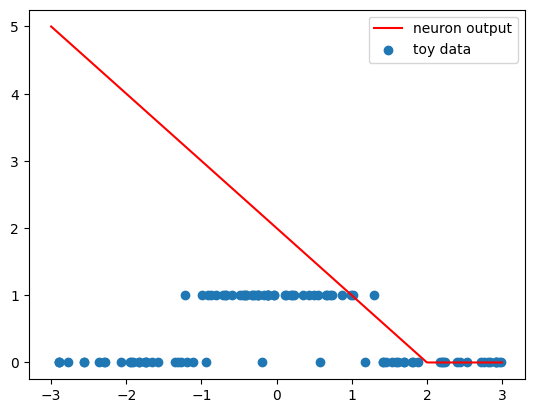

In [9]:
w = -1
b = 2
z = w*x_lin + b
h = relu(z)
plt.plot(x_lin, h, c='r', label='neuron output')
plt.scatter(x, y, label='toy data')
plt.legend();

> **❓Question 2: Predict the Output**
>
> If we change the weights and bias to `w=2, b=-1` instead of `w=-1, b=2`:
>
> 1. In which direction will the ReLU "activate" (for positive x or negative x)?
> 2. At what x-value will the neuron start outputting non-zero values?
> 3. Will the output increase or decrease as x increases beyond that point?
>
> **Try it:** Modify the code in the cell above to test your prediction!

<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Direction: The ReLU will activate for positive x (since the slope $w=2$ is positive).
> 2. Start Point: The neuron starts outputting non-zero values at $x = 0.5$ (solving $2x - 1 = 0$).
> 3. Trend: The output will increase as x increases (slope is positive).

</details>

### Multiple Layers: hidden & output

We saw that we could make two different neurons, each of which fits only *half* of the data well. Can we *combine* them in some way to get better predictions??

Let's try adding them.

<img src='./fig/nn2.png' width=500>

*(Note: The diagram uses different notation:)*
- *z₁, z₂ in diagram → `h1`, `h2` in code (activation outputs)*
- *σ in diagram → we use ReLU*

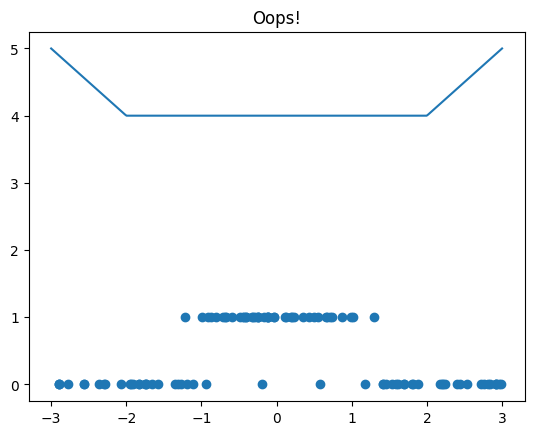

In [10]:
w1, b1 = -1, 2
w2, b2 = 1, 2
z1 = w1*x_lin + b1
z2 = w2*x_lin + b2
h1 = relu(z1)
h2 = relu(z2)
plt.plot(x_lin, h1+h2)
plt.scatter(x, y)
plt.title("Oops!");

We're obviously not there yet! It looks like we might want to scale and shift $h_1$ & $h_2$ again.

In fact, $h_1$ and $h_2$ will become inputs to a *new* **layer**, the **output layer**. Our output layer will give a single neuron because our output is a scalar (the probability of $y=1$).

$h_1$ & $h_2$ are neurons in the **hidden layer**. "Hidden" in the sense that we don't actually observe their outputs; they are passed to the next layer as input. A NN can have *many* hidden layers.

The output neuron is the **output layer** (you can also have multiple output layers, but that is a story for another time!)

The output neuron will need a weight & bias for *both* $h_1$ and $h_2$.

It will also need its own **output activation function**!

### Output Activation

<img src='./fig/nn3.png' width=600>

*(Note: The diagram uses different notation:)*
- *z₁, z₂ in diagram → `h1`, `h2` in code (hidden layer outputs)*
- *W₃₁, W₃₂, W₃₀ → `w31`, `w32`, `b3` in code*
- *q in diagram → `z3` in code (output layer affine result)*
- *σ in hidden layers → we use ReLU; output layer uses sigmoid*

Because we are modeling a binary $y$, we want our output to represent the probability of $y=1$. This means that the output must be in [0,1].

But relu is $[0, \infty]$! We need a different activation function for our output neuron.

What function do you know that has output bounded in [0,1]?

In [11]:
def sigmoid(z: np.ndarray) -> np.ndarray :
    return 1/(1 + np.exp(-z))

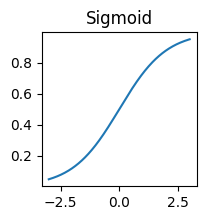

In [12]:
# plot sigmoid activation
plt.figure(figsize=(2,2))
plt.plot(x_lin, sigmoid(x_lin))
plt.title('Sigmoid');

### Constructing our First MLP (Multilayer Perceptron aka a Neural Network)

Now all we need to do is define weights & bias for all three neurons.
**Remember!** The output neuron needs a weight for *each* of its inputs ($h_1$ & $h_2$)

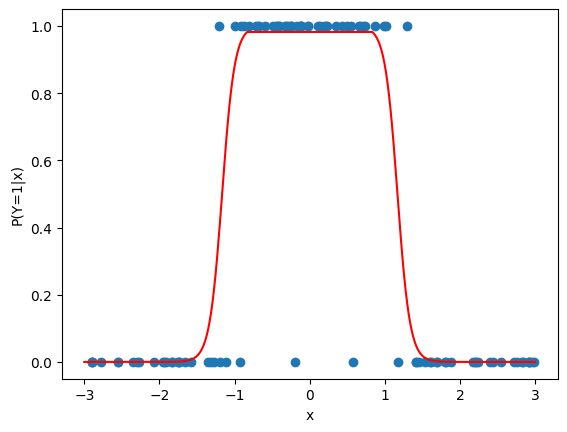

In [13]:
# hidden layer
w1, b1 = 6, -5
w2, b2 = -6, -5
z1 = w1*x_lin + b1
z2 = w2*x_lin + b2
h1 = relu(z1)
h2 = relu(z2)
# output layer
w31, w32, b3 = -2,-2,4
z3 = w31*h1 + w32*h2 + b3
output = sigmoid(z3)

# plot predictions
plt.plot(x_lin, output, c='r')
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('P(Y=1|x)');

Now let us calculate the accuracy of our predictions!

Bear in mind, that what we got so far is not the prediction yet, but rather just probabilities. If a probability is above 0.5, then our prediction is 1, else our prediction is 0.

In [14]:
# hidden layer
z1 = w1*x + b1
z2 = w2*x + b2
h1 = relu(z1)
h2 = relu(z2)
# output layer
z3 = w31*h1 + w32*h2 + b3
p = sigmoid(z3)

# output values > 0.5 are predicted to be 1, otherwise 0
y_hat  = (p > 0.5).astype(int)
# calculate the accuracies
acc = sum((y_hat == y)/len(y))
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9400


## Part 2: NN with PyTorch


**[PyTorch nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)**



Now that we understand what a neural network computes conceptually, we will implement the same ideas using PyTorch.

There are many powerful deep learning packages to work with neural networks like **TensorFlow** and **PyTorch**. These packages provide both the forward and backward propagations, and many other functionalities. The forward pass is used to make predictions while the backward (backpropagation)  is used to  train (optimize) a network. 'Training' refers to find the optimal parameters for a specific task. We'll talk more about optimization and backpropagation next week!

PyTorch provides a simple way to build neural networks using `nn.Sequential` which allows us to stack layers in order.

Here, we use PyTorch's `nn.Sequential` to create a neural network for our toy binary classification problem.\
We'll use the same 'architecture' as above:
- 1 hidden layer with 2 neurons using ReLU activation
- an output layer with 1 neuron using sigmoid activation

In [15]:
torch.manual_seed(42)

# define a sequential model called 'first_model'
model = nn.Sequential(
    # add a hidden layer with 2 neurons and relu activations
    # note we specify the input dimension is 1 (scalar)
    nn.Linear(1, 2),
    nn.ReLU(),
    # add an output layer containing a single neuron with sigmoid activation
    # your code here
    # ...
    ###
    nn.Linear(2, 1),
    nn.Sigmoid()
    ###
)

# display model summary
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)

Total parameters: 7


### Setting up Training

In PyTorch, we define the optimizer and loss function separately, then write a training loop.
Unlike Keras, PyTorch requires us to write our own training loop, which gives us more control over the training process.

`optimizer` - defines how the weights are updated (we'll use SGD; more on this next lecture!)\
`loss` - what the model is trying to minimize (criterion)


<img src='./fig/nn4.png' width=600>



> **❓ Question 3:** Why do I want to track metrics if I already have a loss?


<details>
<summary><em>Click to reveal answer</em></summary>

> Loss (e.g., BCE) is a differentiable function designed for the optimizer to minimize.

> Metrics (e.g., Accuracy) are interpretable measures of actual performance that we care about, even if they aren't differentiable.

</details>

In [16]:
# Define loss function and optimizer
criterion = nn.BCELoss()  
optimizer = optim.SGD(model.parameters(), lr=0.1)

### Fitting the NN

In PyTorch, we write a training loop that:
1. **Forward pass**: Compute predictions
2. **Compute loss**: Compare predictions to targets
3. **Backward pass**: Compute gradients via `loss.backward()`
4. **Update weights**: Apply gradients via `optimizer.step()`

**Training Loop**

Training a neural network is an iterative process.  Each pass through the training loop makes a small adjustment to the model’s  parameters rather than learning everything at once.

```
   X_train --> Forward Pass  -->  Loss --> Backward --> Update Weights
                model(X_train)    BCE      .backward()   optimizer.step()
                │                                                  │
                └─────────────── repeat for N epochs ──────────────┘
```

**Few Notes:**

`batch_size` - number of observations over which the loss is calculated before each weight update (more on this next lecture)\
`epochs` - number of times the complete dataset is seen in the fitting process

**A note on initialization:** Neural network weights are initialized randomly before training. PyTorch's `nn.Linear` uses Kaiming uniform initialization by default, which works well for ReLU networks. However, with  only 2 neurons in our hidden layer, the initial weight *signs* matter: if both weights start positive, both ReLUs "turn off" for negative x values, and the model may converge to a solution that can't predict P(y=1)≈0 on the left side of the data.

We use **Xavier initialization** (`nn.init.xavier_uniform_`) which samples weights from a distribution scaled by the layer sizes. This helps maintain constant variance of activations across layers, improving training stability. The `torch.manual_seed(0)` is set before initialization for reproducibility - with this seed, Xavier produces weights with opposite signs in our first layer, ensuring one neuron stays active for each side of the x-axis. (More on this next week)

In [17]:
# Prepare data as PyTorch tensors
X_tensor = torch.FloatTensor(x.reshape(-1, 1))
y_tensor = torch.FloatTensor(y.reshape(-1, 1))

# Split into train and validation (80/20) with fixed seed for reproducibility
torch.manual_seed(42)
n_train = int(0.8 * len(X_tensor))
indices = torch.randperm(len(X_tensor)) # Randomly permute the indices of the tensor
train_idx, val_idx = indices[:n_train], indices[n_train:]

X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

# Reinitialize model for training (using different seed for better initialization)
torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(1, 2),
    nn.ReLU(),
    nn.Linear(2, 1),
    nn.Sigmoid()
)

# Apply Xavier initialization                                                               
for layer in model:                                                                                          
    if isinstance(layer, nn.Linear):                                                                         
        nn.init.xavier_uniform_(layer.weight)                                                                
        nn.init.zeros_(layer.bias)     
        
# Use SGD optimizer (same as TensorFlow version)
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
epochs = 400
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad() # Zero gradients Reset for next iteration 

    # Forward pass
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass
    # PyTorch automatically computes gradients using a system called autograd.
    # During the forward pass, it records operations; during the backward pass,
    # it applies the chain rule to compute gradients for each parameter.

    loss.backward()
    optimizer.step()

    # Calculate metrics (after weight update)
    model.eval()
    with torch.no_grad():
        y_pred_eval = model(X_train)
        train_acc = ((y_pred_eval > 0.5).float() == y_train).float().mean().item()

        # Validation
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val)
        val_acc = ((y_val_pred > 0.5).float() == y_val).float().mean().item()

    # Store history
    history['loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs} - loss: {loss.item():.4f} - accuracy: {train_acc:.4f} - val_loss: {val_loss.item():.4f} - val_accuracy: {val_acc:.4f}')

Epoch 10/400 - loss: 0.6905 - accuracy: 0.3500 - val_loss: 0.6986 - val_accuracy: 0.2500
Epoch 20/400 - loss: 0.6358 - accuracy: 0.5625 - val_loss: 0.6219 - val_accuracy: 0.5500
Epoch 30/400 - loss: 0.6037 - accuracy: 0.5625 - val_loss: 0.5763 - val_accuracy: 0.5500
Epoch 40/400 - loss: 0.5789 - accuracy: 0.5625 - val_loss: 0.5426 - val_accuracy: 0.5500
Epoch 50/400 - loss: 0.5565 - accuracy: 0.6500 - val_loss: 0.5143 - val_accuracy: 0.5500
Epoch 60/400 - loss: 0.5346 - accuracy: 0.6875 - val_loss: 0.4886 - val_accuracy: 0.7500
Epoch 70/400 - loss: 0.5128 - accuracy: 0.7375 - val_loss: 0.4645 - val_accuracy: 0.8500
Epoch 80/400 - loss: 0.4916 - accuracy: 0.7750 - val_loss: 0.4425 - val_accuracy: 0.8500
Epoch 90/400 - loss: 0.4712 - accuracy: 0.7875 - val_loss: 0.4215 - val_accuracy: 0.8500
Epoch 100/400 - loss: 0.4518 - accuracy: 0.8000 - val_loss: 0.4019 - val_accuracy: 0.9000
Epoch 110/400 - loss: 0.4337 - accuracy: 0.8000 - val_loss: 0.3836 - val_accuracy: 0.9000
Epoch 120/400 - los

### Plot Training History
We stored the training history in a dictionary. Use it to plot the loss across epochs. Don't forget those axis labels! We need to distinguish train from validation.

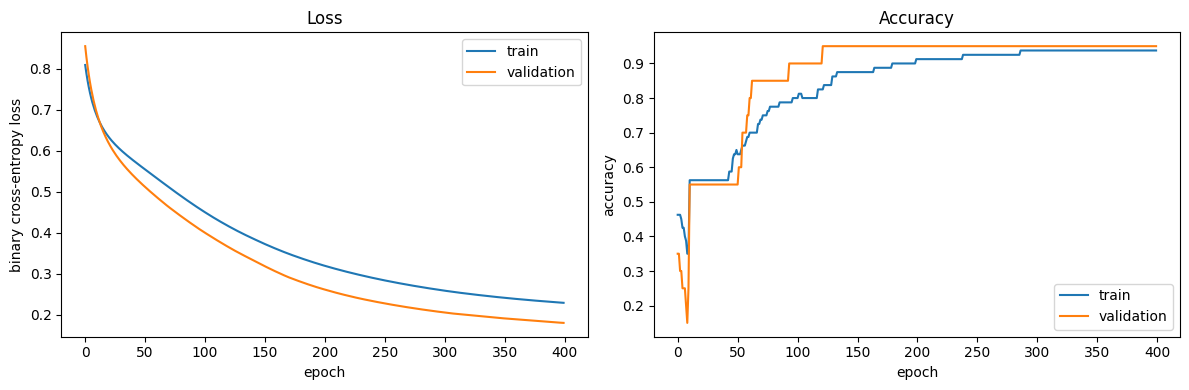

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='validation')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('binary cross-entropy loss')
axes[0].set_title('Loss')
axes[0].legend()

# Accuracy plot
axes[1].plot(history['accuracy'], label='train')
axes[1].plot(history['val_accuracy'], label='validation')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.tight_layout();

In [19]:
# Print final metrics
print(f"Final Training Loss: {history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

Final Training Loss: 0.2295
Final Validation Loss: 0.1806
Final Training Accuracy: 0.9375
Final Validation Accuracy: 0.9500


> **❓Question 4: Interpret the Training Curves**
>
> Look at the training and validation loss/accuracy curves above and answer:
>
> 1. Is the model **overfitting**, **underfitting**, or **well-fit**? How can you tell from the curves?
> 2. If the validation loss started *increasing* while the training loss kept *decreasing*, what would that indicate?
> 3. Based on these curves, would training for more epochs likely improve performance? Why or why not?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. The model is well-fit. The validation loss is low (even lower than training loss) and accuracy is high, showing it generalizes well.
> 2. If validation loss started increasing while training loss decreased, it would indicate overfitting.
> 3. Unlikely - loss seems stable and low

</details>

### Predict & Plot
We use the model in evaluation mode on a linspace, `x_lin`, which we previously constructed to span the range of the dataset's $x$ values. We save the resulting predictions in `y_hat`

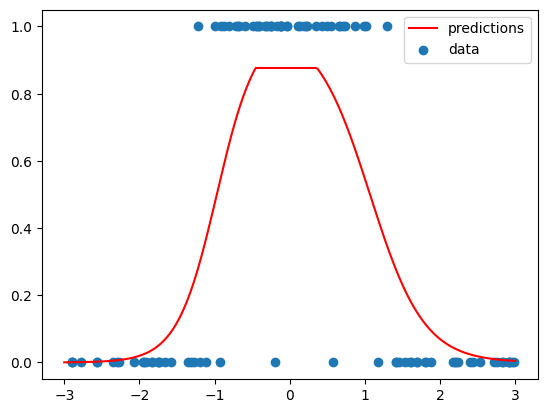

In [20]:
model.eval()
with torch.no_grad():
    X_lin_tensor = torch.FloatTensor(x_lin.reshape(-1, 1))
    y_hat = model(X_lin_tensor).numpy()

plt.plot(x_lin, y_hat, c='r', label='predictions')
plt.scatter(x, y, label='data')
plt.legend();

In [21]:
# Evaluate the model on the full dataset
# (Note that in this example we did not have a separate test set!)
model.eval()
with torch.no_grad():
    y_pred_full = model(X_tensor)
    loss_full = criterion(y_pred_full, y_tensor)
    acc_full = ((y_pred_full > 0.5).float() == y_tensor).float().mean()
print(f'Loss: {loss_full.item():.4f}, Accuracy: {acc_full.item():.4f}')

Loss: 0.2195, Accuracy: 0.9400


In [22]:
# View model weights & biases for all layers
for name, param in model.named_parameters():
    print(f'{name}: {param.data}')

0.weight: tensor([[ 1.7728],
        [-1.8393]])
0.bias: tensor([-0.6441, -0.8340])
2.weight: tensor([[-1.5685, -2.0595]])
2.bias: tensor([1.9594])


**Interpreting the weights and biases:**

Based on the tensor shapes, our model has a **1 → 2 → 1** architecture:
```
Input (1) → Linear(1,2) → ReLU → Linear(2,1) → Sigmoid → Output
             layer 0      layer 1    layer 2     layer 3
```

**Layer 0 (input → hidden):**
- `0.weight` shape `(2, 1)`: Each row is a hidden neuron's weight for the single input
- `0.bias` shape `(2,)`: One bias per hidden neuron

Each hidden neuron computes: `activation = input × weight + bias`

**Layer 2 (hidden → output):**
- `2.weight` shape `(1, 2)`: The output neuron's weights for each hidden neuron
- `2.bias` shape `(1,)`: The output neuron's bias

**Why are layers 1 and 3 missing?** ReLU and Sigmoid are activation functions with no learnable parameters, so they don't appear in `named_parameters()`.

**Naming convention:** `{layer_index}.{parameter_type}` — the index corresponds to the layer's position in the Sequential model.

### Save & Reload model
Fitting non-trivial neural networks can take a long time. It is important to know how to save and reload your PyTorch models.

Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)


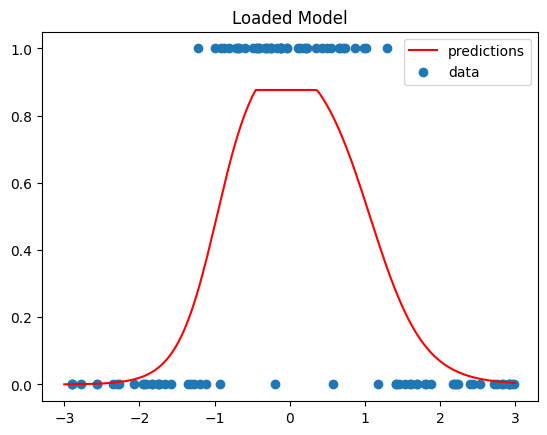

In [23]:
# save model
torch.save(model.state_dict(), 'first_pytorch_model.pth')

# To reload, first recreate the model architecture
model_reload = nn.Sequential(
    nn.Linear(1, 2),
    nn.ReLU(),
    nn.Linear(2, 1),
    nn.Sigmoid()
)
# Then load the saved weights
model_reload.load_state_dict(torch.load('first_pytorch_model.pth', weights_only=True))
model_reload.eval()

# display summary
print(model_reload)

# Confirm we can make predictions with loaded model
with torch.no_grad():
    y_hat = model_reload(X_lin_tensor).numpy()

plt.plot(x_lin, y_hat, c='r', label='predictions')
plt.scatter(x, y, label='data')
plt.title("Loaded Model")
plt.legend();

### An Ugly Function (Regression Example)

Now let's try a regression task where the response variable we are modeling can take on any real value.

In [24]:
def ugly_function(x):
    if x < 0:
        return np.exp(-(x**2))/2 + 1 + np.exp(-((10*x)**2))
    else:
        return np.exp(-(x**2)) + np.exp(-((10*x)**2))

How do you feel about the prospect of manually setting the weights to approximate this beauty?

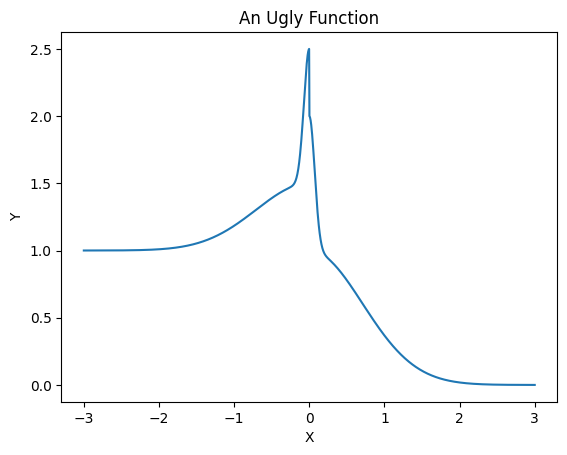

In [25]:
# Generate data
x_ugly = np.linspace(-3,3,1500) # create x-values for input
y_ugly = np.array(list(map(ugly_function, x_ugly)))

# Plot data
plt.plot(x_ugly, y_ugly);
plt.title('An Ugly Function')
plt.xlabel('X')
plt.ylabel('Y');

---

## 🏋️ TEAM ACTIVITY: Build Model

We're Gonna Need a Bigger Model...

---
  

Construct an NN to approximate the ugly function with PyTorch's `nn.Sequential`.

**Build Model & Display Summary**

You can play with the number of hidden (`Linear`) layers and the number of neurons in each.

Think about what should the output activation function be for a regression task?

In [26]:
# your code here
ugly_model = nn.Sequential(
    nn.Linear(1, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1)  # No activation for regression (linear output)
)

print(ugly_model)
print(f"\nTotal parameters: {sum(p.numel() for p in ugly_model.parameters())}")

Sequential(
  (0): Linear(in_features=1, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=8, bias=True)
  (7): ReLU()
  (8): Linear(in_features=8, out_features=1, bias=True)
)

Total parameters: 2881


**Compile (Setup Optimizer & Loss)**\
Use the `SGD` optimizer and `MSELoss` as your loss.\
You can experiment with the `learning_rate`.

In [27]:
# your code here

criterion_ugly = nn.MSELoss()
optimizer_ugly = optim.SGD(ugly_model.parameters(), lr=0.1)

**Fit**\
Fit `ugly_model` on `x_ugly` and `y_ugly`.\
You can experiment with the number of `epochs`.

In [28]:
# your code here
# Prepare data
X_ugly_tensor = torch.FloatTensor(x_ugly.reshape(-1, 1))
y_ugly_tensor = torch.FloatTensor(y_ugly.reshape(-1, 1))

# Training loop
epochs = 2500
ugly_history = {'loss': []}

for epoch in range(epochs):
    ugly_model.train()
    optimizer_ugly.zero_grad()

    y_pred = ugly_model(X_ugly_tensor)
    loss = criterion_ugly(y_pred, y_ugly_tensor)

    loss.backward()
    optimizer_ugly.step()

    ugly_history['loss'].append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs} - MSE: {loss.item():.6f}')

Epoch 100/2500 - MSE: 0.018676
Epoch 200/2500 - MSE: 0.012700
Epoch 300/2500 - MSE: 0.010291
Epoch 400/2500 - MSE: 0.008750
Epoch 500/2500 - MSE: 0.007504
Epoch 600/2500 - MSE: 0.006392
Epoch 700/2500 - MSE: 0.005380
Epoch 800/2500 - MSE: 0.004519
Epoch 900/2500 - MSE: 0.004572
Epoch 1000/2500 - MSE: 0.004850
Epoch 1100/2500 - MSE: 0.004512
Epoch 1200/2500 - MSE: 0.004173
Epoch 1300/2500 - MSE: 0.003827
Epoch 1400/2500 - MSE: 0.003517
Epoch 1500/2500 - MSE: 0.003265
Epoch 1600/2500 - MSE: 0.002939
Epoch 1700/2500 - MSE: 0.002737
Epoch 1800/2500 - MSE: 0.002557
Epoch 1900/2500 - MSE: 0.002374
Epoch 2000/2500 - MSE: 0.002194
Epoch 2100/2500 - MSE: 0.002057
Epoch 2200/2500 - MSE: 0.001939
Epoch 2300/2500 - MSE: 0.001777
Epoch 2400/2500 - MSE: 0.001686
Epoch 2500/2500 - MSE: 0.001559


**Plot Training History**

Plot the model's training history. Don't forget your axis labels!\
**Hint:** Remember, we stored the history in a dictionary during training.

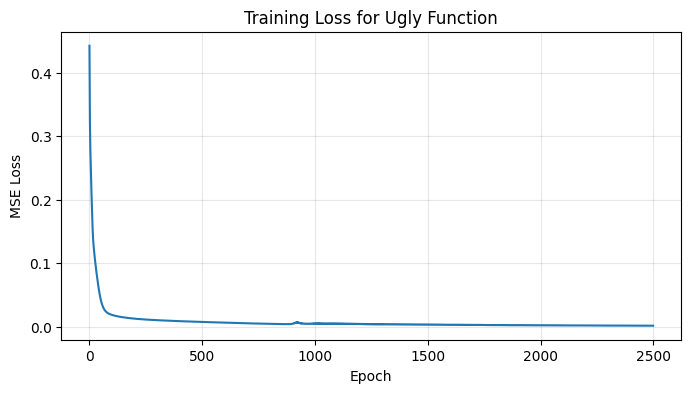

In [29]:
# Plot History
# your code here
plt.figure(figsize=(8, 4))
plt.plot(ugly_history['loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss for Ugly Function')
plt.grid(True, alpha=0.3);

**Get Predictions**\
Use your model to predict on `x_ugly` and store the results in a variable called `y_hat_ugly`.

In [30]:
# Predict
# your code here
ugly_model.eval()
with torch.no_grad():
    y_hat_ugly = ugly_model(X_ugly_tensor).numpy()

**Plot Predictions**\
Run the cell below to compare your model's predictions to the true (ugly) function. Still not quite right? Try tweaking some of the hyperparameters above and re-run the cells in this section to see if you can improve.

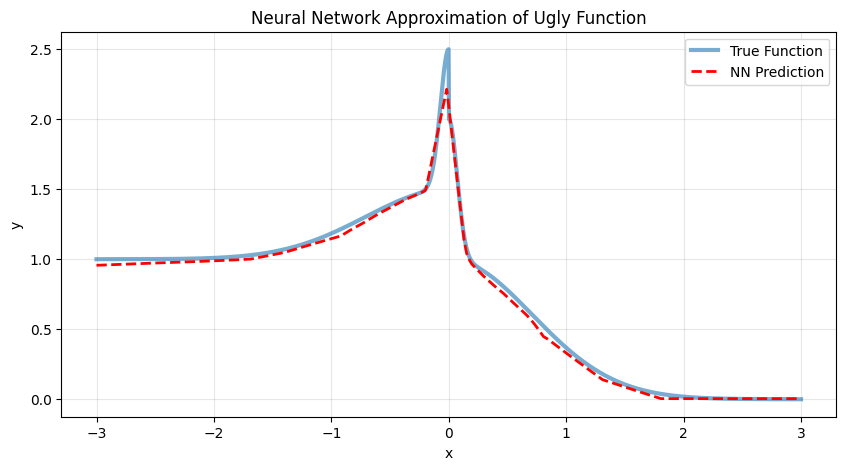

In [31]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(x_ugly, y_ugly, alpha=0.6, lw=3, label='True Function')
plt.plot(x_ugly, y_hat_ugly, label='NN Prediction', ls='--', c='r', lw=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network Approximation of Ugly Function')
plt.legend()
plt.grid(True, alpha=0.3);

Not bad!

**End of team activity**

## Appendix - Multi-class Classification with PyTorch + Bagging 

So far we've only used our new PyTorch powers for toy regression and binary classification problems. Now we'll try classification with 3 classes!

This example will use `seaborn`'s penguins dataset (last time, I promise!)

We'll build a model to identify a penguin's species from its other features. In the process we'll dust off our Python skills with a *very* quick run through of a basic model building workflow.

In [32]:
# Bring on the penguins!
penguins = pd.read_csv('data/penguins.csv')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


We have 3 species of penguins living across 3 different islands. There are measurements of bill length, bill depth, flipper length, and body mass. We also have categorical variable for each penguin's sex giving us a total of 7 features.

Here's a plot that tries to show too much at once. But you can ignore the marker shapes and sizes. The bill and flipper length alone ($x$ and $y$ axes) seem to already provide a fair amount of information about the species (color).

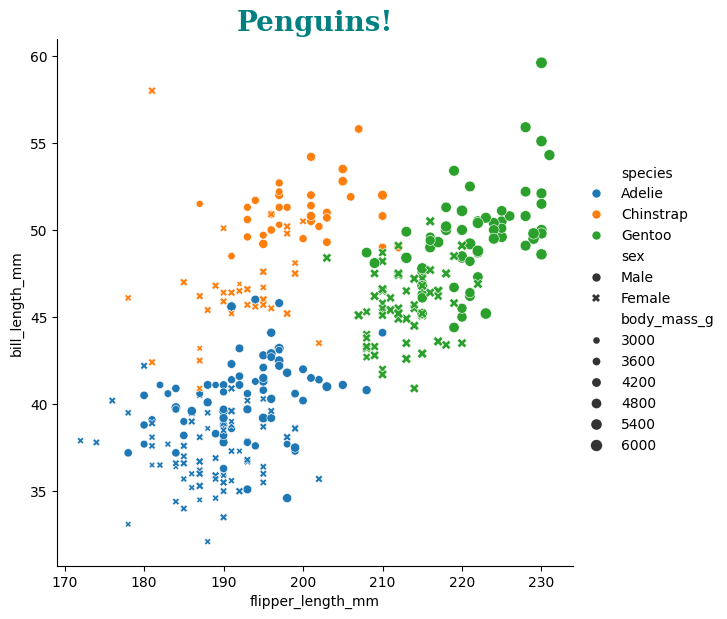

In [33]:
# Plot penguins with too much info
sns.relplot(data=penguins, x='flipper_length_mm', y='bill_length_mm',
            hue='species', style='sex', size='body_mass_g', height=6);
plt.title('Penguins!', fontdict={'color': 'teal', 'size': 20, 'weight': 'bold', 'family': 'serif'});

We've taken care of *most* of the preprocessing in a separate notebook called `penguin_data.ipynb` and stored the results in `data/penguins_proc.csv`.

Let's start from that file instead.

In [34]:
penguins = pd.read_csv("data/penguins_proc.csv")
penguins.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,island_nan,sex_Male,sex_nan,species
0,39.1,18.7,181.0,3750.0,False,True,False,True,False,Adelie
1,39.5,17.4,186.0,3800.0,False,True,False,False,False,Adelie
2,40.3,18.0,195.0,3250.0,False,True,False,False,False,Adelie
3,36.7,19.3,193.0,3450.0,False,True,False,False,False,Adelie
4,39.3,20.6,190.0,3650.0,False,True,False,True,False,Adelie


In [35]:
# Separate features from response
X_design = penguins.drop("species", axis=1)
y = penguins.species

But there are a few things we still need to do.

**Feature Scaling**

We should take a closer look at the range of values our predictors take on.

In [36]:
#  Summary stats of predictors
X_design.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Our features are not on the same scale. Just compare the min/max of `bill_depth_mm` and `body_mass_g` for example.\
This can slow down neural network training for reasons we'll see in an upcoming lecture.

Let's make use of `sklearn`'s `StandardScaler` to standardize the data, centering each predictor at 0 and setting their standard deviations to 1.

In [37]:
# Remember the column names for later; we'll lose them when we scale
X_cols = X_design.columns
# Saving the scaler object in a variable allows us to reverse the transformation later
scaler = StandardScaler()
num_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
X_scaled = X_design.copy()
X_scaled[num_cols] = scaler.fit_transform(X_design[num_cols])

In [38]:
# The scaler was passed a pandas DataFrame but returns a numpy array
type(X_scaled), X_scaled.shape

(pandas.core.frame.DataFrame, (342, 9))

In [39]:
# We can always add the column names back later if we need to
pd.DataFrame(X_scaled, columns=X_cols).head(3)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,island_nan,sex_Male,sex_nan
0,-0.884499,0.785449,-1.418347,-0.564142,False,True,False,True,False
1,-0.811126,0.126188,-1.062250,-0.501703,False,True,False,False,False
2,-0.664380,0.430462,-0.421277,-1.188532,False,True,False,False,False


**Encoding the Response Variable**

In [40]:
# Take a look at our response
y

0      Adelie
1      Adelie
2      Adelie
3      Adelie
4      Adelie
        ...  
337    Gentoo
338    Gentoo
339    Gentoo
340    Gentoo
341    Gentoo
Name: species, Length: 342, dtype: object

Our response variable is still a `string`. We need to turn it into some numerical representation for our neural network.\
We could to this ourselves with a few list comprehensions, but `sklearn`'s `LabelEncoder` makes this very easy.

In [41]:
# Encode string labels as integers
# LabelEncoder uses the familiar fit/transform methods we saw with StandardScaler
labenc = LabelEncoder().fit(y)
y_enc = labenc.transform(y)
y_enc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [42]:
# We can recover the class labels from the encoder object later
labenc.classes_

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In PyTorch, for multi-class classification with `CrossEntropyLoss`, we can use integer labels directly (no one-hot encoding needed). The loss function expects:
- Predictions: raw logits of shape (N, C) where C is number of classes
- Targets: class indices of shape (N,) as integers

We'll use integer labels with CrossEntropyLoss (more efficient in PyTorch).

> **❓Question 5: Predict & Interpret Multi-class Output**
>
> Suppose a trained penguin classifier outputs raw logits `[2.0, 0.5, -1.0]` for a single observation, where index 0=Adelie, 1=Chinstrap, 2=Gentoo.
>
> 1. Which species will be predicted (before applying softmax)?
> 2. After applying softmax, the probabilities become approximately `[0.78, 0.17, 0.04]`. What does this tell us about the model's confidence?
> 3. Why does PyTorch's `CrossEntropyLoss` expect raw logits instead of softmax probabilities?

<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Adelie (index 0) will be predicted since it has the highest logit value (2.0).
> 2. The model is fairly confident (~78%) about Adelie, somewhat considers Chinstrap (~17%), and is quite sure it's not Gentoo (~4%).
> 3. CrossEntropyLoss applies log-softmax internally for numerical stability. Computing softmax then log separately can cause numerical underflow/overflow issues.

</details>


**Train-test Split**

You may be familiar with using `train_test_split` to split the `X` and `y` arrays themselves. But here we will using it to create a set of train and test *indices*.

We'll see later that being able to determine which rows in the original `X` and `y` ended up in train or test will be helpful.

**Q:** But couldn't we just sample integers to get random indices? Why use `train_test_split`?

**A:** Because `train_test_split` allows for **stratified** splitting!

We'll stratify on `sex_Male`. By stratifying on this column we help ensure that proportion of male penguins is roughly equal in both train and test.

In [43]:
# Create train/test indices
train_idx, test_idx = train_test_split(np.arange(X_scaled.shape[0]),
                                                  test_size=0.5,
                                                  random_state=109,
                                                  stratify=X_scaled['sex_Male'])

In [44]:
# Index into X_scaled and y_enc to create the train and test sets
X_train = X_scaled.iloc[train_idx].values  # Convert to numpy for PyTorch
y_train = y_enc[train_idx]
X_test = X_scaled.iloc[test_idx].values
y_test = y_enc[test_idx]

In [45]:
# Sanity check on the resulting shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((171, 9), (171,), (171, 9), (171,))

**Validation Split**

We can also stratify for our validation split.

In [46]:
# Create train and validation splits from original train split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.5,
                                                    random_state=109,
                                                    stratify=X_scaled.iloc[train_idx]["sex_Male"])

---

### Building the Penguin Classifier

Now let's put everything together and build, train, and evaluate a multi-class neural network classifier for our penguin species.

---
  
  > 💡 **Note:** We use these PyTorch modules: `torch`, `nn`, `F`, `optim`

**Build**

We'll construct a neural network penguin classifier. Since we're using PyTorch's `CrossEntropyLoss`, we don't need a softmax activation on the output layer—the loss function applies it internally.

We determine the input and output dimensions programmatically from the data rather than hard-coding them.

In [47]:
# Build the model and print summary
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))

torch.manual_seed(42)
model = nn.Sequential(
    nn.Linear(input_size, 8),
    nn.ReLU(),
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Linear(16, output_size)  # No softmax - CrossEntropyLoss handles it
)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=3, bias=True)
)

Total parameters: 275


**Setup Optimizer and Loss**

We'll use `SGD` as our optimizer with a learning rate of 0.1.
For multi-class classification, `CrossEntropyLoss` is the appropriate loss function—it combines `LogSoftmax` and `NLLLoss` in a single class.

In [48]:
# Setup optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

**Fit**

Next we write a training loop for the model. We'll train for 50 epochs and track both training and validation metrics throughout the process.

In [49]:
# Training loop

# Convert data to tensors (ensure float/int types)
X_train_t = torch.FloatTensor(X_train.astype(np.float32))
y_train_t = torch.LongTensor(y_train.astype(np.int64))
X_val_t = torch.FloatTensor(X_val.astype(np.float32))
y_val_t = torch.LongTensor(y_val.astype(np.int64))

# Training parameters
epochs = 50
history = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    
    # Calculate training accuracy
    _, predicted = torch.max(outputs, 1)
    train_acc = (predicted == y_train_t).float().mean()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_t)
        val_loss = criterion(val_outputs, y_val_t)
        _, val_predicted = torch.max(val_outputs, 1)
        val_acc = (val_predicted == y_val_t).float().mean()
    
    # Store history
    history['loss'].append(loss.item())
    history['acc'].append(train_acc.item())
    history['val_loss'].append(val_loss.item())
    history['val_acc'].append(val_acc.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Acc: {train_acc.item():.4f} - Val Loss: {val_loss.item():.4f} - Val Acc: {val_acc.item():.4f}')

Epoch 10/50 - Loss: 1.0450 - Acc: 0.5176 - Val Loss: 1.0244 - Val Acc: 0.4884
Epoch 20/50 - Loss: 0.9979 - Acc: 0.6118 - Val Loss: 0.9590 - Val Acc: 0.6512
Epoch 30/50 - Loss: 0.9114 - Acc: 0.6941 - Val Loss: 0.8362 - Val Acc: 0.7791
Epoch 40/50 - Loss: 0.7627 - Acc: 0.7647 - Val Loss: 0.6430 - Val Acc: 0.8721
Epoch 50/50 - Loss: 0.6085 - Acc: 0.7765 - Val Loss: 0.4678 - Val Acc: 0.8721


**Plot**

Let's visualize the loss and accuracy across training epochs. We include both **training** and **validation** scores to monitor for overfitting.

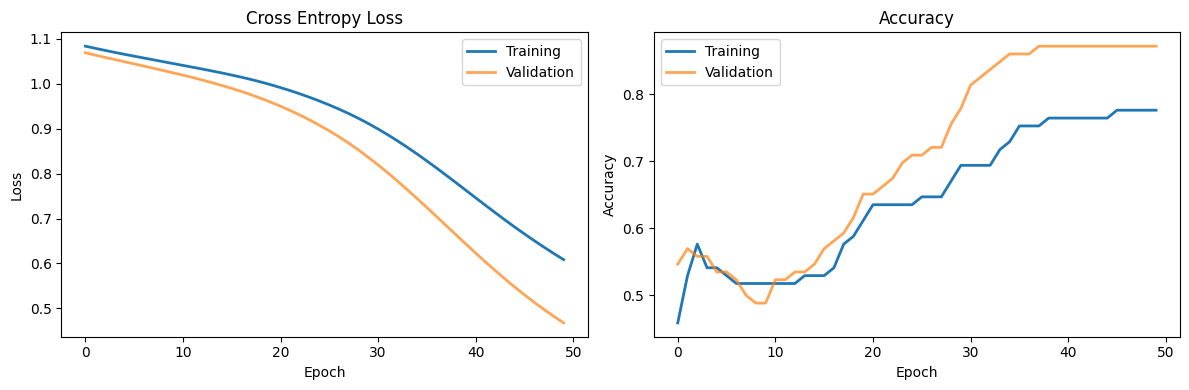

In [50]:
# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axs[0].plot(history['loss'], linewidth=2, label='Training')
axs[0].plot(history['val_loss'], linewidth=2, label='Validation', alpha=0.7)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Cross Entropy Loss')
axs[0].legend()

# Accuracy plot
axs[1].plot(history['acc'], linewidth=2, label='Training')
axs[1].plot(history['val_acc'], linewidth=2, label='Validation', alpha=0.7)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

### Evaluating the Model

First, let's see how well we could to by simply predicting the majority class in the training data for all observations.

In [51]:
# Calculate naive accuracy (majority class baseline)
most_common_class = Counter(y_train).most_common(1)[0][1]
naive_acc = most_common_class / len(y_train)
print('Naive Accuracy:', naive_acc)

Naive Accuracy: 0.47058823529411764


In [52]:
# Helper function to evaluate model
def evaluate_model(model, X, y, criterion):
    model.eval()
    with torch.no_grad():
        X_t = torch.FloatTensor(X.astype(np.float32))
        y_t = torch.LongTensor(y.astype(np.int64))
        outputs = model(X_t)
        loss = criterion(outputs, y_t)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_t).float().mean()
    return loss.item(), accuracy.item()

print('Train:', evaluate_model(model, X_train, y_train, criterion))
print('Validation:', evaluate_model(model, X_val, y_val, criterion))
print('Test:', evaluate_model(model, X_test, y_test, criterion))

Train: (0.5954654216766357, 0.7764706015586853)
Validation: (0.46777117252349854, 0.8720930218696594)
Test: (0.5809341669082642, 0.7777777910232544)


---

### Bagging
You'll be using bagging ("bootstrap aggregating") in your HW so let's take a minute to review the idea and see how it would work with a PyTorch model.
    
The idea is to simulate multiple datasets by sampling our current one with replacement and fitting a model on this sample. The process is repeated multiple times until we have an *ensemble* of fitted models, all trained on slightly different datasets.
    
We can then treat the ensemble as a single 'bagged' model. When it is time to predict, each model in the ensemble makes its own predictions. These predictions can then be *aggregated* across models, for example, by taking the average or through majority voting.
    
We may also be interested in looking at the distribution of the predictions for a given observation as this may help us quantify our uncertainty in a way in which we could not with a single model's predictions (even if that model outputs a probability!)

**NN Build Function**

**Arguments:**
- `name`: str - A name for your NN.
- `input_dim`: int - number of predictors in input
- `hidden_dims`: list of int - specifies the number of neurons in each hidden layer
    - Ex: [2,4,8] would mean 3 hidden layers with 2, 4, and 8 neurons respectively
- `hidden_act`: activation function used by all hidden layers
- `out_dim`: int - number of output neurons a.k.a 'output units'
- `out_act`: activation function used by output layer (or None)

**Hint:** We will reuse this function throughout the notebook in different settings, but you should go ahead and set some sensible defaults for *all* of the arguments.

In [53]:
def build_NN(name='NN', input_dim=1, hidden_dims=[2], hidden_act=nn.ReLU, out_dim=1, out_act=None):
    """Build a neural network with configurable architecture 
    """
    layers = []
    prev_dim = input_dim

    for hidden_dim in hidden_dims:
        layers.append(nn.Linear(prev_dim, hidden_dim))
        layers.append(hidden_act())
        prev_dim = hidden_dim

    layers.append(nn.Linear(prev_dim, out_dim))
    if out_act is not None:
        layers.append(out_act())

    return nn.Sequential(*layers)

In [54]:
# Set up parameters for the bagging process
learning_rate = 1e-1
epochs = 50
n_boot = 30
bagged_models = []
np.random.seed(109)
torch.manual_seed(109)

for n in range(n_boot):
    # Bootstrap
    boot_idx = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
    X_train_boot = X_train[boot_idx]
    y_train_boot = y_train[boot_idx]

    # Convert to tensors, ensuring X_train_boot is float32
    X_boot_tensor = torch.FloatTensor(X_train_boot.astype(np.float32))
    y_boot_tensor = torch.LongTensor(y_train_boot)

    # Build
    boot_model = build_NN(name=f'penguins_{n}',
                         input_dim=X_train_boot.shape[1],
                         hidden_dims=[8, 16, 32],
                         hidden_act=nn.ReLU,
                         out_dim=3,
                         out_act=None)  # No softmax, CrossEntropyLoss handles it

    # Setup optimizer and loss
    optimizer = optim.SGD(boot_model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    boot_model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = boot_model(X_boot_tensor)
        loss = criterion(outputs, y_boot_tensor)
        loss.backward()
        optimizer.step()

    # Store bootstrapped model
    bagged_models.append(boot_model)

In [55]:
# Notice we can programatically recover the shape of a model's output layer
m = bagged_models[0]
# Get the last Linear layer
for layer in reversed(list(m.modules())):
    if isinstance(layer, nn.Linear):
        out_dim = layer.out_features
        break
print(out_dim)

3


In [56]:
def get_bagged_pred(bagged_models, X):
    # Number of observations
    n_obs = X.shape[0]
    # Number of models in the bagged ensemble
    n_models = len(bagged_models)
    # Get prediction dimensions from first model
    for layer in reversed(list(bagged_models[0].modules())):
        if isinstance(layer, nn.Linear):
            pred_dim = layer.out_features
            break

    # 3D tensor to store predictions from each bootstrapped model
    # n_observations x n_classes x n_models
    boot_preds = np.zeros((n_obs, pred_dim, n_models))

    # Store all predictions in the tensor
    X_tensor = torch.FloatTensor(X.astype(np.float32)) # Convert to float32 here
    for i, model in enumerate(bagged_models):
        model.eval()
        with torch.no_grad():
            # Apply softmax to get probabilities
            probs = F.softmax(model(X_tensor), dim=1)
            boot_preds[:,:,i] = probs.numpy()

    # Average the predictions across models
    bag_pred = boot_preds.mean(axis=-1)
    return bag_pred, boot_preds

In [57]:
# Get aggregated and unaggregated ensemble predictions
bag_pred, boot_preds = get_bagged_pred(bagged_models, X_test)

In [58]:
# Example of aggregated predictions
bag_pred[:3]

array([[0.33250966, 0.20420556, 0.46328477],
       [0.29970445, 0.18915719, 0.51113835],
       [0.51954742, 0.23678846, 0.24366411]])

In [59]:
# Shape of unaggregated ensemble predictions tensor
boot_preds.shape

(171, 3, 30)

In [60]:
# Calculate bagged accuracy
bag_acc = sum(bag_pred.argmax(axis=-1) == y_test)/bag_pred.shape[0]
print(f'Single Model Test Acc: {evaluate_model(model, X_test, y_test, criterion)[1]:.4f}')                                   
print(f'Bagged Acc: {bag_acc:.4f}')  

Single Model Test Acc: 0.7778
Bagged Acc: 0.7778
